In [39]:
import pandas as pd
import glob
import json


import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
json_files = glob.glob('*.json')
json_files

['file.json', 'file2.json', 'file3.json']

In [71]:
pd.set_option('display.max_columns', None)
df = pd.DataFrame()
for path in json_files:
    with open(path) as f:
        data = json.load(f)
        df1 = pd.json_normalize(data, max_level = 4)
        df = pd.concat([df,df1], axis=0)

#df

In [28]:
df.shape

(3, 736)

In [72]:
columns_to_select = ['id', 'type', 'tool_name', 'os_name','system.owner','cpu.cpus.cpu0.vendor', 'cpu.cpus.cpu0.family', 'cpu.cpus.cpu0.device'
                    ,'cpu.cpus.cpu0.features.lira_suite']

# Create a subset of the DataFrame based on the specified columns
subset_df = df[columns_to_select]
#subset_df

In [73]:
numerical_columns = df.select_dtypes(include=['number'])

# Create a new DataFrame with only numerical columns
numerical_df = df[numerical_columns.columns]
#numerical_df

In [31]:
numerical_df.shape

(3, 97)

In [74]:
df = pd.concat([subset_df, numerical_df], axis=1)
#df

In [75]:
null_percentage = (df.isnull().sum() / len(df)) * 100

# Set a threshold (60% in this case)
threshold = 60

# Identify columns with null values exceeding the threshold
columns_to_drop = null_percentage[null_percentage > threshold].index

# Remove columns with more than 60% null values
df = df.drop(columns=columns_to_drop)
#df

In [76]:
df = df.dropna(axis=1, how='any')
#df

In [35]:
# !pip install category-encoders

In [56]:
# Seperating the categorical and numerical columns
categorical_columns = df.select_dtypes(['object', 'category']).columns.tolist()
print(cat_cols)


numerical_columns = df.select_dtypes(['int64','float64']).columns.tolist()
print(num_cols)

['id', 'type', 'tool_name', 'os_name', 'system.owner', 'cpu.cpus.cpu0.vendor', 'cpu.cpus.cpu0.family', 'cpu.cpus.cpu0.device', 'cpu.cpus.cpu0.features.lira_suite']
['system.onecloud_id', 'bios.boot_time', 'cpu.cpus.cpu0.cores', 'cpu.cpus.cpu0.max_speed_mhz', 'cpu.cpus.cpu1.cores', 'cpu.cpus.cpu1.max_speed_mhz', 'cpu.cpu_count', 'ram.dimm_count', 'ram.size_gib', 'storage.disks.disk0.size_gib', 'storage.disk_count', 'storage.total_gib', 'pci.0000_00_1f_0.width', 'pci.0000_00_1f_0.link_speed_gts', 'nic.nics.nic0.link_speed_mbps', 'nic.nics.nic0.port_count', 'nic.nic_count', 'usb.1_4_1_0.class_id', 'firmware.firmware_count', 'instrumentation.serial_port_0.port', 'instrumentation.serial_port_1.port', 'instrumentation.serial_port_2.port', 'instrumentation.serial_port_3.port', 'instrumentation.pdu.port']


In [60]:
# Create transformers for categorical and numerical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
     ('scaler', StandardScaler())
])

# Create a ColumnTransformer to apply transformers to the respective column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create a final preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


In [61]:
preprocessing_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['system.onecloud_id',
                                                   'bios.boot_time',
                                                   'cpu.cpus.cpu0.cores',
                                                   'cpu.cpus.cpu0.max_speed_mhz',
                                                   'cpu.cpus.cpu1.cores',
                                                   'cpu.cpus.cpu1.max_speed_mhz',
                                                   'cpu.cpu_count',
                                                   'ram.dimm_count',
                                                   'ram.size_gi...
                                                   'instrumentation.serial_port_3.port',
                                                   'instrumentation.pdu.port']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['id', 'type', 'tool_name',
                                                   'os_name', 'system.owner',
                                                   'cpu.cpus.cpu0.vendor',
                                                   'cpu.cpus.cpu0.family',
                                                   'cpu.cpus.cpu0.device',
                                                   'cpu.cpus.cpu0.features.lira_suite'])]))])

In [62]:
# Apply the preprocessing pipeline to your data
X_preprocessed = preprocessing_pipeline.fit_transform(df)


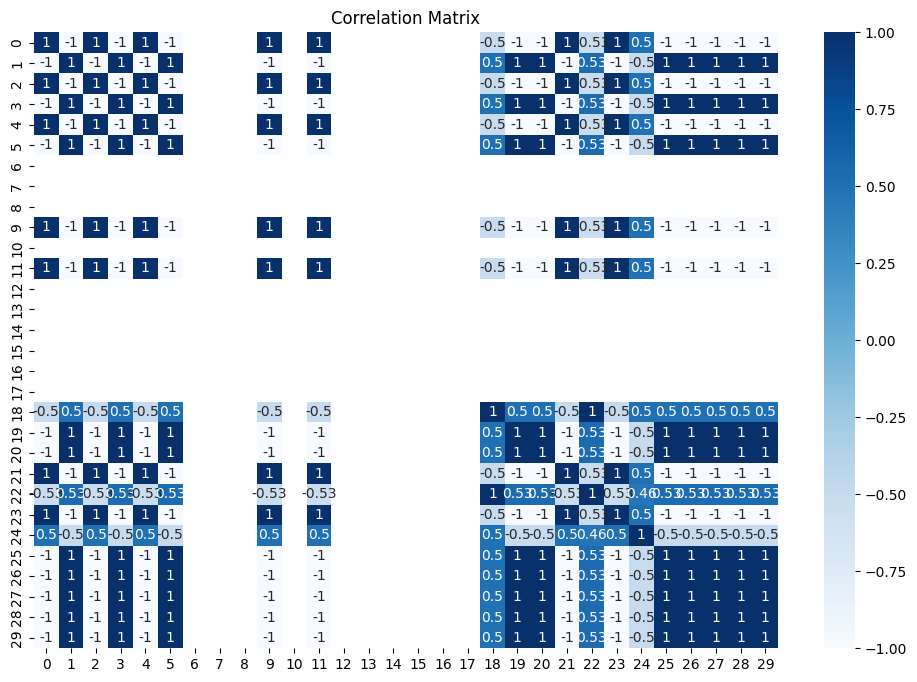

In [66]:
# Calculate the correlation matrix
correlation_matrix = np.corrcoef(X_preprocessed, rowvar=False)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()


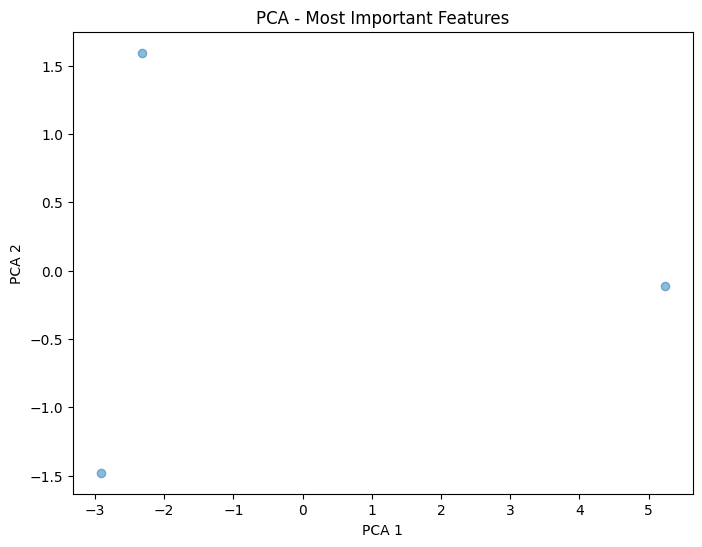

In [69]:
# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])

# Plot the most important features using PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA - Most Important Features')
plt.show()


/home/sancheet/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


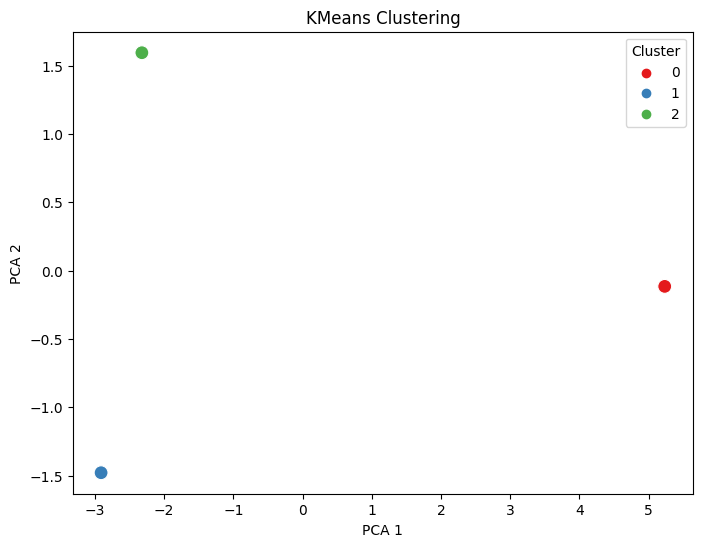

In [70]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(X_pca)

# Add cluster labels to the PCA DataFrame
pca_df['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=100)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clustering')
plt.show()


In [64]:
matrix = X_preprocessed.corr()

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

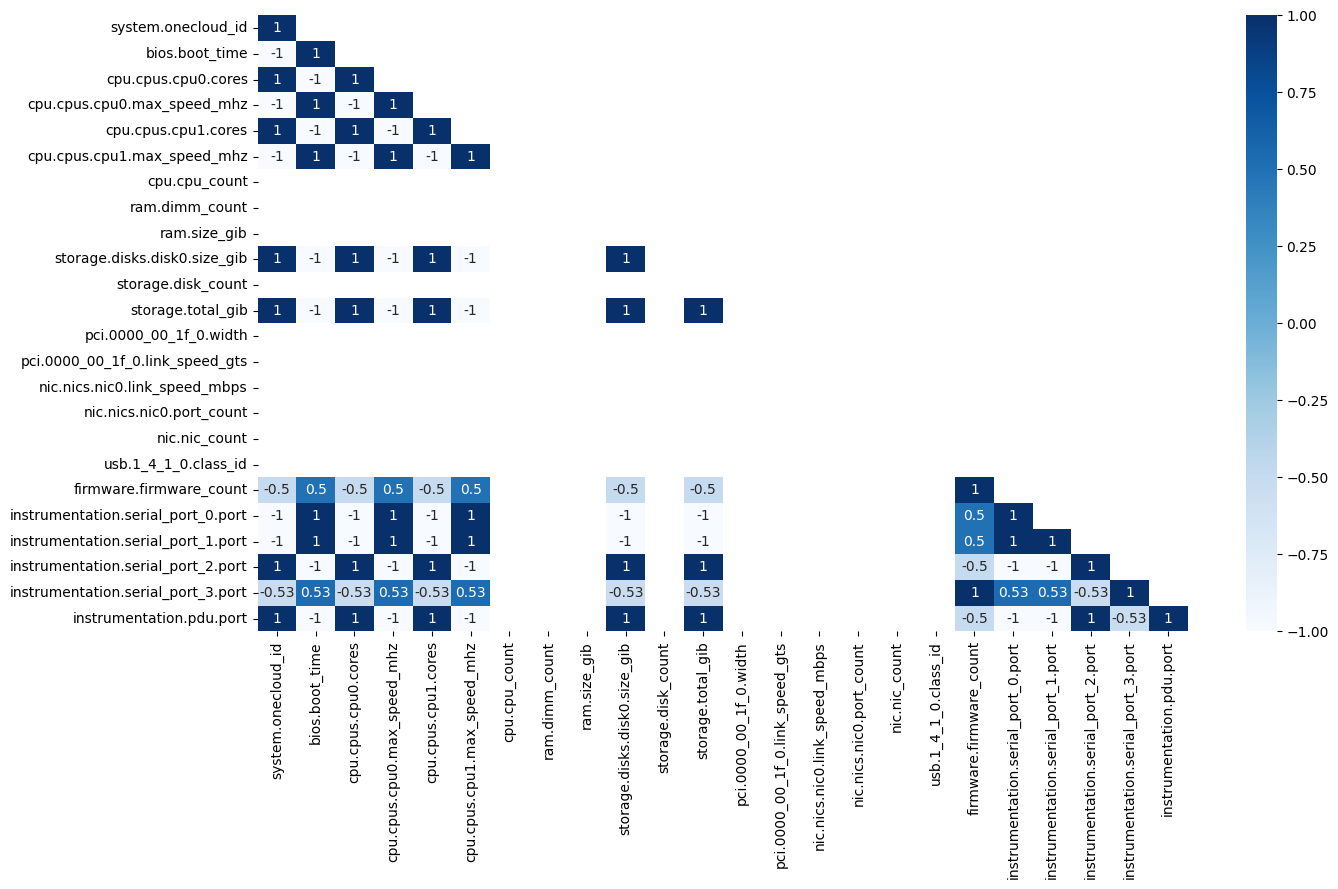

In [40]:
fig = plt.figure(figsize=(15,8))
ax = sns.heatmap(matrix, cmap='Blues' ,mask=np.triu(matrix, k=1),annot=True,)
ax.set_facecolor('white')

plt.show()

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(df)
data_pca = pca.transform(df)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])
data_pca.head()

ValueError: could not convert string to float: 'cs17ca101bs0202'

In [22]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['system.onecloud_id',
                                                   'bios.boot_time',
                                                   'cpu.cpus.cpu0.cores',
                                                   'cpu.cpus.cpu0.max_speed_mhz',
                                                   'cpu.cpus.cpu1.cores',
                                                   'cpu.cpus.cpu1.max_speed_mhz',
                                                   'cpu.cpu_count',
                                                   'ram.dimm_count',
                                                   'ram.size_gi...
                                                   'instrumentation.pdu.port']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['id', 'type', 'tool_name',
                                                   'os_name', 'system.owner',
                                                   'cpu.cpus.cpu0.vendor',
                                                   'cpu.cpus.cpu0.family',
                                                   'cpu.cpus.cpu0.device',
                                                   'cpu.cpus.cpu0.features.lira_suite'])])),
                ('K Means Clustering', KMeans(n_clusters=2))])

In [14]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [15]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

In [17]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=2)

In [18]:
model = Pipeline(steps=[('preprocessor', preprocessor),("K Means Clustering", kmeans_model)])

In [24]:
model.fit(df)

/home/sancheet/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['system.onecloud_id',
                                                   'bios.boot_time',
                                                   'cpu.cpus.cpu0.cores',
                                                   'cpu.cpus.cpu0.max_speed_mhz',
                                                   'cpu.cpus.cpu1.cores',
                                                   'cpu.cpus.cpu1.max_speed_mhz',
                                                   'cpu.cpu_count',
                                                   'ram.dimm_count',
                                                   'ram.size_gi...
                                                   'instrumentation.pdu.port']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['id', 'type', 'tool_name',
                                                   'os_name', 'system.owner',
                                                   'cpu.cpus.cpu0.vendor',
                                                   'cpu.cpus.cpu0.family',
                                                   'cpu.cpus.cpu0.device',
                                                   'cpu.cpus.cpu0.features.lira_suite'])])),
                ('K Means Clustering', KMeans(n_clusters=2))])

In [30]:
# Get cluster labels and cluster centers
labels = model.named_steps['K Means Clustering'].labels_
cluster_centers = model.named_steps['K Means Clustering'].cluster_centers_


In [34]:
# Visualize the clustered data
plt.scatter(df[:, 0], df[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=200, c='red', label='Cluster Centers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')
plt.legend()
plt.show()


InvalidIndexError: (slice(None, None, None), 0)